## Creating RIDGE Regression Model :<br/>  to predict house sale price 

### Importing Packages &  Load Data 

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso,LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
import pickle


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [6]:
#define the file path to import the cleaned dataset
file_path = '../datasets/train_clean.csv'
train = pd.read_csv(file_path)

### Preprocessing & Modeling:

The following columns are the selected features that will be used in our model:<br>
- overall_qual
- gr_live_area
- garage_area
- total_bsmt_sf
- year_remod/add
- totrms_abvgrd
- 1st_flr_sf
- year_built
- fireplaces

The `saleprice` is target; the column that model will be predicting.

**From preprocessing to building the model:**<br>

**1)** Creating features matrix (X) and target vector (y) - `features matrix`(X) = all  independence variables  and `target vector` (y) = dependant variabvle that model will predict:

In [7]:
#creating `X` and `y` variables
features = ['overall_qual','gr_liv_area', 'year_remod/add', 'totrms_abvgrd', 
'garage_area',  '1st_flr_sf', 'year_built', 'fireplaces']
X = train[features] # feature matrix
y = np.log(train['saleprice']) # target vector log treansformed to nomalize distribution 

**2)** Instantiate and fitting model:

In [8]:
model = Ridge(alpha =10)

In [9]:
model.fit(X, y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [10]:
cross_val_score(model, X, y, cv=5).mean()

0.8234632837582019

>**2.1) Feature Engineering:** Before moving forward, checking to see if model score can be optimized through feature engineering - method used :<br>
- `Interaction Terms` : combination of features matrix (creates an interation of one feature with anoher) 

As shown below, model $R^2$ got improved from 0.82 t0 0.85 - thus moving forward with the new featured model:  

In [11]:
#using PolynomialFeatures for interaction terms  
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
poly_model = Ridge(alpha =10)
poly_model.fit(X_poly, y);
cross_val_score(poly_model, X_poly, y, cv=5).mean()

0.8479025016280666

**3)** Splitting (X) and (y) into train and test sets:

In [12]:
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, random_state = 42)

>**3.1)** Scaling features matrix to standardize the data. This helps to remove the mean and scaling to unit variance for more normal distribution:

In [13]:
ss = StandardScaler()
ss.fit(X_poly_train)
X_train_sc = ss.transform(X_poly_train)
X_test_sc = ss.transform(X_poly_test) 


In [14]:
#Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)


# Cross-validate over our list of ridge alphas.
poly_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
poly_model = poly_model.fit(X_train_sc, y_train)

Running `coef` and `intercept` to check the bias and coefficnet for each selected feature. in cells below, intercept indicates the average price for a house without any of the selected feature, while  coef indicates the expected price increase per added feature, holding all other variables constant. 

In [15]:
poly_model.intercept_

12.022826060510466

In [16]:
poly_model.coef_

array([ 0.0473178 ,  0.05088533,  0.02053311, -0.00915288,  0.01785316,
        0.05610296,  0.02189749,  0.01545771, -0.0641333 ,  0.04577484,
        0.04133184,  0.04074433,  0.03590428,  0.04921499,  0.03579742,
       -0.0012328 , -0.03351934,  0.05654835,  0.00679751, -0.03187862,
       -0.08620472,  0.05197826,  0.00159153,  0.02087799, -0.00214386,
        0.01867691,  0.05758593,  0.01885064,  0.01206668, -0.00779345,
        0.02084303, -0.03325675, -0.0061851 ,  0.01427533, -0.00382723,
       -0.03859973,  0.01644998, -0.01304919, -0.07463843,  0.05708047,
        0.01136729,  0.01437903,  0.00503368, -0.00051249])

**4)** Get the baseline score for both train/test sets (cross validation) for evaluation:

In [17]:
#Look into train score
cross_val_score(poly_model, X_train_sc, y_train, cv=5).mean()

0.8414286744855085

In [18]:
#Look into test score
cross_val_score(poly_model, X_test_sc, y_test, cv=5).mean()

0.8374374162967999

**5)** Genereting model prediction and finding the line of best fit:

In [19]:
#model predictions
y_prediction_train = poly_model.predict(X_train_sc)

In [20]:
#model predictions
y_prediction_test = poly_model.predict(X_test_sc)

In [21]:
metrics.r2_score(y_train, y_prediction_train)

0.8582855025102268

In [22]:
# 85% of the variance in the dependant variable can be exlained by this model.
metrics.r2_score(y_test, y_prediction_test)

0.8457144052059531

In [23]:
residual_test = y_test - y_prediction_test

In [24]:
residual_train = y_train - y_prediction_train

Plotting residual to check if variance between our low predictions and our high predictions is considtent, the plot below shows that our target is almost normally distributed. However, it might require normalization for features with extreme outlier: 

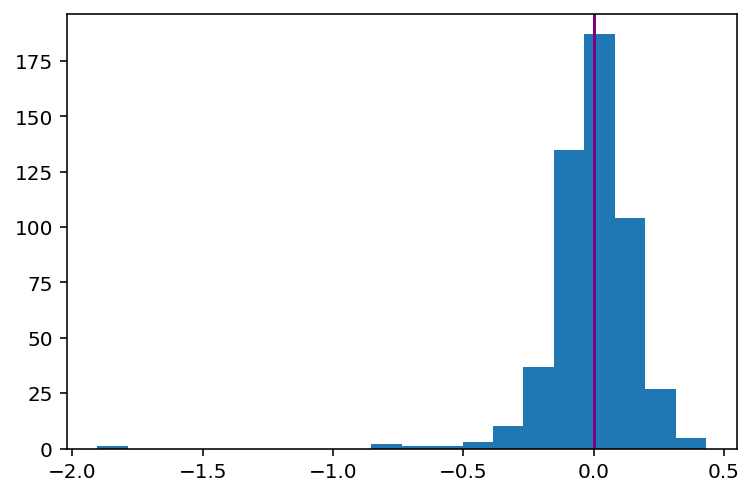

In [25]:
plt.hist(residual_test, bins = 20, )
plt.axvline(0, color = 'purple');
plt.savefig('../plots/residual_hist.png')
#plt.title('Residual (sale price  - actual vs predicted)', fontsize = 12);

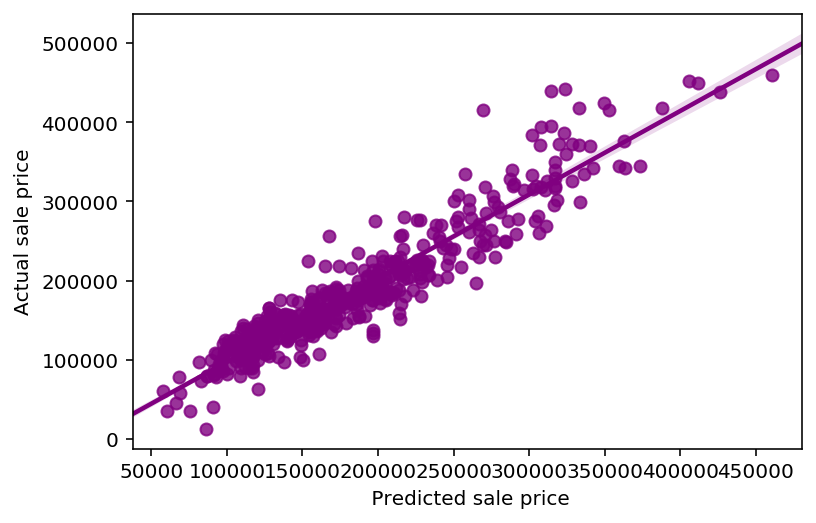

In [26]:

sns.regplot(np.exp(y_prediction_test), np.exp(y_test), color='purple')
plt.xlabel(" Predicted sale price")
plt.ylabel("Actual sale price");
#plt.title("Line of Best Fit", fontsize = 12);

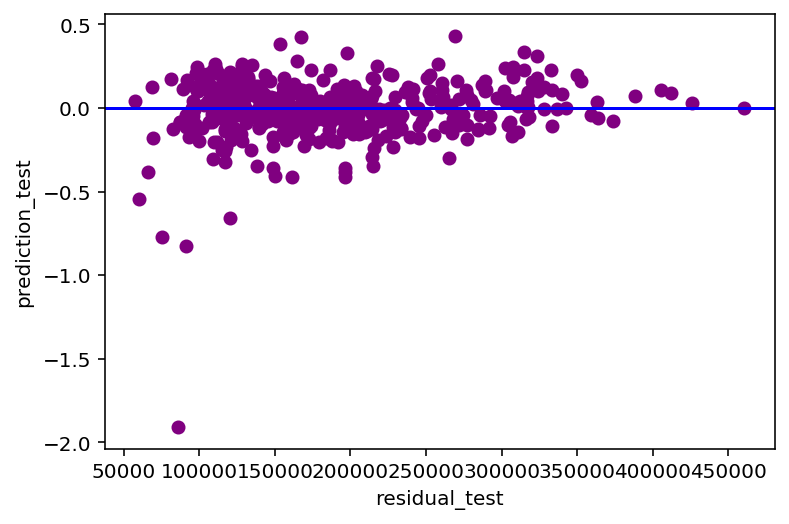

In [27]:
plt.scatter(np.exp(y_prediction_test), residual_test, color = 'purple')
plt.axhline(0, color='b');
plt.xlabel("residual_test")
plt.ylabel("prediction_test")
plt.savefig('../plots/prediction_residual.png')

**Regression Metrics:** 

**MAE** shows by average our model is 0.11 point off:

In [28]:
# TRAIN - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_train,y_prediction_train)

0.1098980277884912

In [29]:
#TEST - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_test,y_prediction_test)

0.10832391190888892

**MSE** is the average sum of all errors squared and should be as close to 0 as possible. our model shows a low MSE for both train /test sets. this indicates that the model is fairly fit.

In [30]:
# TRAIN - Mean Squarred Error represents avg distance squared from the predicted value.
metrics.mean_squared_error(y_train, y_prediction_train)

0.02349569366978727

In [31]:
#TEST - Mean Squarred Error represents avg distance squared from the predicted value.
metrics.mean_squared_error(y_test, y_prediction_test)

0.02761262850963719

**RMSE** the goal is always to get RMSE as close to 0 as possible - RMSE indicates that the model is approx off by +/-$27K when predicting the house's sale price.

In [32]:
#TRAIN - Root Mean Squared Error represents avg distance from the predicted value.
#using np.exp to inverse the log transform for saleprice
np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_prediction_test)))

26128.48454154821

In [33]:
#TEST- Root Mean Squared Error represents avg distance from the predicted value.
np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(y_prediction_train)))

28389.247922588605

In [34]:
# Importing the stats model API
import statsmodels.api as sm
# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              saleprice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.257e+06
Date:                Wed, 15 Jan 2020   Prob (F-statistic):                        0.00
Time:                        17:44:47   Log-Likelihood:                          706.10
No. Observations:                2051   AIC:                                     -1396.
Df Residuals:                    2043   BIC:                                     -1351.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
overall_qual       0.0963      0.004     25.889      0.000       0.089       0.104
gr_liv_area        0.0002   1.63e-05     10.506      0.000       0.000       0.000
year_remod/add     0.0032      0.000     18.664      0.000       0.003       0.004
totrms_abvgrd      0.0058      0.004      1.361      0.174      -0.003       0.014
garage_area        0.0002    2.3e-05      9.315      0.000       0.000       0.000
1st_flr_sf         0.0001   1.25e-05      9.573      0.000    9.53e-05       0.000
year_built         0.0023      0.000     13.359      0.000       0.002       0.003
fireplaces         0.0792      0.007     11.477      0.000       0.066       0.093
==============================================================================
Omnibus:                     1561.963   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            84293.109
Skew:                          -3.070   Prob(JB):                         0.00
Kurtosis:                      33.801   Cond. No.                     6.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Below cell shows the impact of each feature on property's sale price, for example,  if the house has a fireplace, we expect to see about 8% increase in the sale price.

In [35]:
np.exp(model.params)

overall_qual      1.101055
gr_liv_area       1.000172
year_remod/add    1.003178
totrms_abvgrd     1.005827
garage_area       1.000214
1st_flr_sf        1.000120
year_built        1.002314
fireplaces        1.082466
dtype: float64

#### Conclusion and Recommendations:

As of now **`84.6%`** of variance in the sale price can be explained by this model, indicating that the model is just right. In other words,  model can generalize from train/test data to predict the house value, with **`+/-$28K`** price error. This model is built using numeric datasets, and can be improved by leveraging feature engineerign to include few key features like Neighborhood  by leveraincluding some key features like Neighborgood, style and materials. Nevertheless, this model can be used for the following purposes:<br>

<>**Prediction**<> <br>
This model can be used for any dataset that includes similar attributes on house features to predict the property's selling price.<br>

<>**Inference**<> <br>
This model can be used to outline and test some of the most important factors/features that influence house's value. 